# Logistic Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import datasets, metrics
import warnings
warnings.filterwarnings("ignore")

### Sigmoids

The sigmoid function is given by 

$\sigma(z) = \frac{1}{1 + e^{-z}}$

Implement this below.

In [2]:
def sigmoid(z):
    ### BEGIN SOLUTION
    z = 1/(1+np.exp(-z))
    ### END SOLUTION
    return z

As noted in lecture, the output should lie between 0 and 1, centred at 0.5.

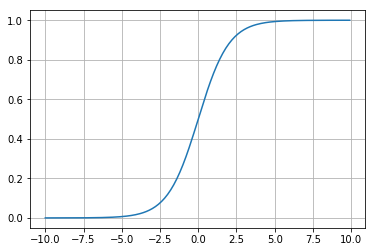

In [3]:
x = np.arange(-10,10,0.1)
y = sigmoid(x)
plt.grid()
plt.plot(x,y)
plt.show()

### Loss Function

To fit a Logistic Regression model for binary classification, the loss function (negative of the likelihood) is given by

$l(\beta) = - \frac{1}{n} \sum_{i=1}^{n} \{ y_i \log p(x_i;\beta) + (1-y_i) \log (1 - p(x_i;\beta))\}$

where $p(x_i;\beta) = p(Y = 1 | X = x_i) = \frac{1}{1 + e^{-(\beta^T x_i)}} = \sigma(\beta^T x_i)$

Note that $\beta_0$ has been folded into the vector $\beta$, as in Linear Regression, by adding a column of ones to the data matrix $X$.

Implement the given loss function below. You can use the vector form of the loss function, given by

$l(\beta) = - \frac{1}{n} \{ y_i \log (\sigma(X^T\beta)) + (1-y_i) \log (\sigma(X^T\beta))\}$

In [4]:
def loss_function(beta, X, y):
    ### BEGIN SOLUTION
    n = y.size
    z = np.dot(X,beta)
    h = sigmoid(z)
    loss =  (-1./n)*(np.dot(y.T,np.log(h)) + np.dot((1 - y).T,np.log(1 - h)))
    if np.isnan(loss):
        return(np.inf)
    ### END SOLUTION
    return loss

In [5]:
# Adding a column of ones to get intercept coefficient beta_0 
def add_intercept(X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)

### A simple optimizer - Gradient Descent

To obtain the Logistic Regression classifier, we need to find the parameters that will minimize the loss function defined above. As noted in the lecture, usually a Newton-Raphson or similar optimizer is used in practice (including in the sklearn package). 

For this example, we will implement a simple gradient descent optimizer as follows.

1. Initialize $\beta$ to be a vector of zeros, and set learning rate $lr$
2. For each iteration of gradient descent
   
   - Compute the gradient of the loss function
   
      $grad(l) = \frac{1}{n}(X^T(\sigma(\beta^T X) - y))$
   
   - Update the parameters
   
      $\beta \leftarrow \beta - (lr*grad)$
      
      
3. Repeat step 2 till the number of iterations runs out, or the change in loss is less than some tolerance value (say 0.0001)

In [6]:
def fit(X,y,lr=0.01, num_iter=1000, tol=1E-4):
    ### BEGIN SOLUTION
    X = add_intercept(X)
    beta = np.zeros(X.shape[1])
    prev_loss = 0
    for i in range(num_iter):
        z = np.dot(X, beta)
        h = sigmoid(z)
        n = y.size
        gradient = (1./n)*np.dot(X.T, (h - y))
        beta -= lr * gradient
        loss = loss_function(beta,X,y)
        
        if(i%50 ==0):
            print('loss: ' + str(loss))
            
        if (np.abs(loss - prev_loss) < tol):
            break
    ### END SOLUTION
    return beta

The above function will find the coefficients $\beta$ for the model. We can now make predictions for a test input $x$. This is done by finding the conditional probability $p(Y = 1 | X = x)$, and then thresholding at 0.5.

$p(Y = 1 | X = x) = \frac{1}{1 + e^{-(\beta^T x)}} = \sigma(\beta^T x)$

$g(x) = 
\begin{cases}
1 \text{ if } p(Y = 1 | X = x) \ge 0.5 \\
0 \text{ if } p(Y = 1 | X = x) < 0.5
\end{cases}$

Implement these below.

In [7]:
# Return the probability P(Y=1|X=x)
def predict_prob(X,beta):
    ### BEGIN SOLUTION
    X = add_intercept(X)
    p = sigmoid(np.dot(X, beta))
    ### END SOLUTION
    return p

In [8]:
# Return the predictions for the model (0 or 1)
def predict(X,beta):
    ### BEGIN SOLUTION
    g = predict_prob(X,beta).round()
    ### END SOLUTION
    return g

# Trying out the classifier

Let's use the following toy data.

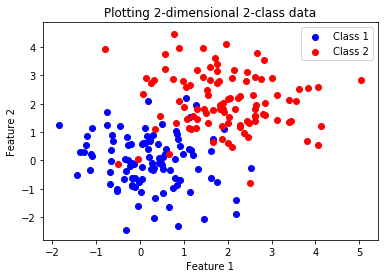

In [9]:
def generate_2d_data(class1Mean, class1Cov, class2Mean, class2Cov, plot=False):
    
    np.random.seed(1)
    class1x = np.random.multivariate_normal(class1Mean, class1Cov, 100)
    class1y = np.zeros(100)
    class2x = np.random.multivariate_normal(class2Mean, class2Cov, 100)
    class2y = np.ones(100)
    x = np.concatenate((class1x, class2x), axis=0)
    y = np.concatenate((class1y, class2y))

    if(plot==True):
        # Plotting the 2-class data
        plt.title('Plotting 2-dimensional 2-class data')
        plt.scatter(class1x[:,0], class1x[:,1], color = 'b', label = 'Class 1')
        plt.scatter(class2x[:,0], class2x[:,1], color = 'r', label = 'Class 2')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.legend()
        plt.show()
    
    return x,y

class1Mean = [0, 0]
class1Cov = [[1, 0], [0,1]]

class2Mean = [2, 2]
class2Cov = [[1, 0], [0,1]]

X,y = generate_2d_data(class1Mean, class1Cov, class2Mean, class2Cov, plot=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [10]:
def plot(X, y, theta=None, model_type=None, clf=None, show_vectors=False):

    cmap = plt.cm.coolwarm
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = .02    
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    temp = np.c_[xx.ravel(), yy.ravel()]

    if(model_type=='sklearn'):
        P = clf.predict(temp).reshape(yy.shape)
    else:
        P = predict(temp,theta).reshape(yy.shape)
    plt.pcolormesh(xx, yy, P, cmap=cmap)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, edgecolor='k')    
    
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.xticks(())
    plt.yticks(())
    plt.show()

Train the model below, using a learning rate of 0.01. Print the loss every 50 iterations so that you can monitor the progress of the algorithm.

loss: 0.689179569118822
loss: 0.5683011689133312
loss: 0.5155111963238566
loss: 0.48354170923647666
loss: 0.4601027436062915
loss: 0.44114799124459103
loss: 0.4250286297046417
loss: 0.41094293030364004
loss: 0.3984381610319512
loss: 0.38722503272353337
loss: 0.37710006586014944
loss: 0.36790979647634514
loss: 0.35953276444114174
loss: 0.35186966430999556
loss: 0.3448375097868417
loss: 0.33836590530280514
loss: 0.3323944982223635
loss: 0.32687113715127725
loss: 0.32175048030113285
loss: 0.3169929081562236
Accuracy: 0.95


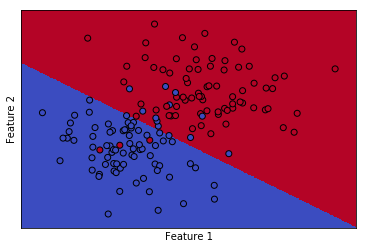

In [11]:
### BEGIN SOLUTION
beta = fit(X_train,y_train)
y_pred = predict(X_test,beta)
print('Accuracy: ' + str(metrics.accuracy_score(y_test,y_pred)))
### END SOLUTION
plot(X_train,y_train,beta)

For comparison, here is the result of scikit-learn's Logistic Regression implementation.

Accuracy = 0.95


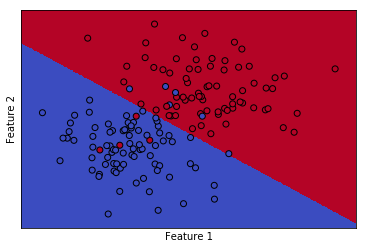

In [12]:
X,y = generate_2d_data(class1Mean, class1Cov, class2Mean, class2Cov)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

clf = LogisticRegression()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print('Accuracy = ' + str(metrics.accuracy_score(y_test,y_pred)))
plot(X_train,y_train,model_type='sklearn',clf=clf)

### Another example - odd and even digits

Here is a dataset of digits, where the label is set to 0 if the digit is even and 1 if the digit is odd.

In [13]:
data = datasets.load_digits()
X = data.data
y = (data.target % 2 == 0) * 1
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.4,random_state=123)

Use the Logistic Regression classifier as above, with a learning rate of 0.01, for this task.

In [14]:
### BEGIN SOLUTION
beta = fit(X_train,y_train)
y_pred = predict(X_test,beta)
### END SOLUTION
print('Accuracy = ' + str(metrics.accuracy_score(y_test,y_pred)))

loss: 0.5447583821023472
loss: 0.24819981932833093
loss: 0.1947773417764467
loss: 0.18465230088011772
loss: 0.17925712452117773
loss: 0.17536932434198466
loss: 0.17240733745889503
loss: 0.17007036327532024
loss: 0.168179578923821
loss: 0.16662000709462102
loss: 0.16531366298645703
loss: 0.16420550336423512
loss: 0.1632554431235545
loss: 0.1624335373988763
loss: 0.16171693516008004
loss: 0.1610878794556154
loss: 0.1605323535379809
loss: 0.16003914006628542
loss: 0.1595991525366775
loss: 0.1592049507731939
Accuracy = 0.9040333796940194


You can see a few of the model's predictions plotted below.

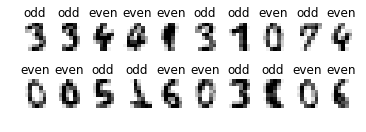

In [15]:
images_and_predictions = list(zip(X_test, y_pred))
for index, (image, prediction) in enumerate(images_and_predictions[:20]):
    plt.subplot(4, 10, index + 11)
    plt.axis('off')
    plt.imshow(image.reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')
    if(prediction==1):
        plt.title('even')
    elif(prediction==0):
        plt.title('odd')

### On the fence

One of the advantages of the Logistic Regression classifier is that we directly obtain the probabilities associated with every prediction.

Let us look at the predictions that the classifier has made with lower confidence. Obtain all the predictions for which the probability is between 0.45 and 0.55. 

In [16]:
###BEGIN SOLUTION
p = predict_prob(X_test,beta)
uncertain_indices = np.where((p<0.55) & (p>0.45))[0]
X_uncertain = X_test[uncertain_indices,:]
y_uncertain = y_test[uncertain_indices]
p_uncertain = p[uncertain_indices]
### END SOLUTION
print(p_uncertain)

[0.48463892 0.46013624 0.54688829 0.459675   0.53804701 0.529442
 0.49048719 0.48562486 0.53908053 0.52297592 0.54745763 0.50130992
 0.45892307 0.50128225 0.4992486  0.52501714 0.49308374]


Now plot 10 of these digits and examine the predictions.

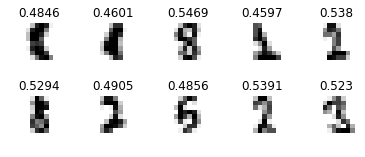

In [17]:
### BEGIN SOLUTION
images_and_predictions = list(zip(X_uncertain, np.round(p_uncertain,4)))
plt.subplots_adjust(left = 0.125,right = 0.9, bottom = 0.01,top = 0.9, wspace = 1, hspace = 1 )
for index, (image, predicted_prob) in enumerate(images_and_predictions[:10]):
    plt.subplot(4, 5, index + 6)
    plt.axis('off')
    plt.imshow(image.reshape(8,8), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title(str(predicted_prob))
### BEGIN SOLUTION

# Decision Trees

In [18]:
import graphviz
from sklearn import tree
import pandas as pd

Let us work with the Pima Indians Diabetes dataset. This dataset has 8 features.

In [19]:
feature_names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'output']
data = pd.read_csv('pima-indians-diabetes.data', sep=",", header=None, names=feature_names)
feature_names = feature_names[:-1]
X = data.values[:,:-1]
y = data.values[:,-1].astype(int)
num_attributes = X.shape[1]
data.head()

preg  plas  pres  skin  test  mass   pedi  age  output
0     6   148    72    35     0  33.6  0.627   50       1
1     1    85    66    29     0  26.6  0.351   31       0
2     8   183    64     0     0  23.3  0.672   32       1
3     1    89    66    23    94  28.1  0.167   21       0
4     0   137    40    35   168  43.1  2.288   33       1

Classify the given dataset using a Decison Tree.

In [20]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=5)
### BEGIN SOLUTION
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = metrics.accuracy_score(y_pred,y_test)
print(acc)
### END SOLUTION

0.70995670995671


You can use GraphViz to visualize the learned tree

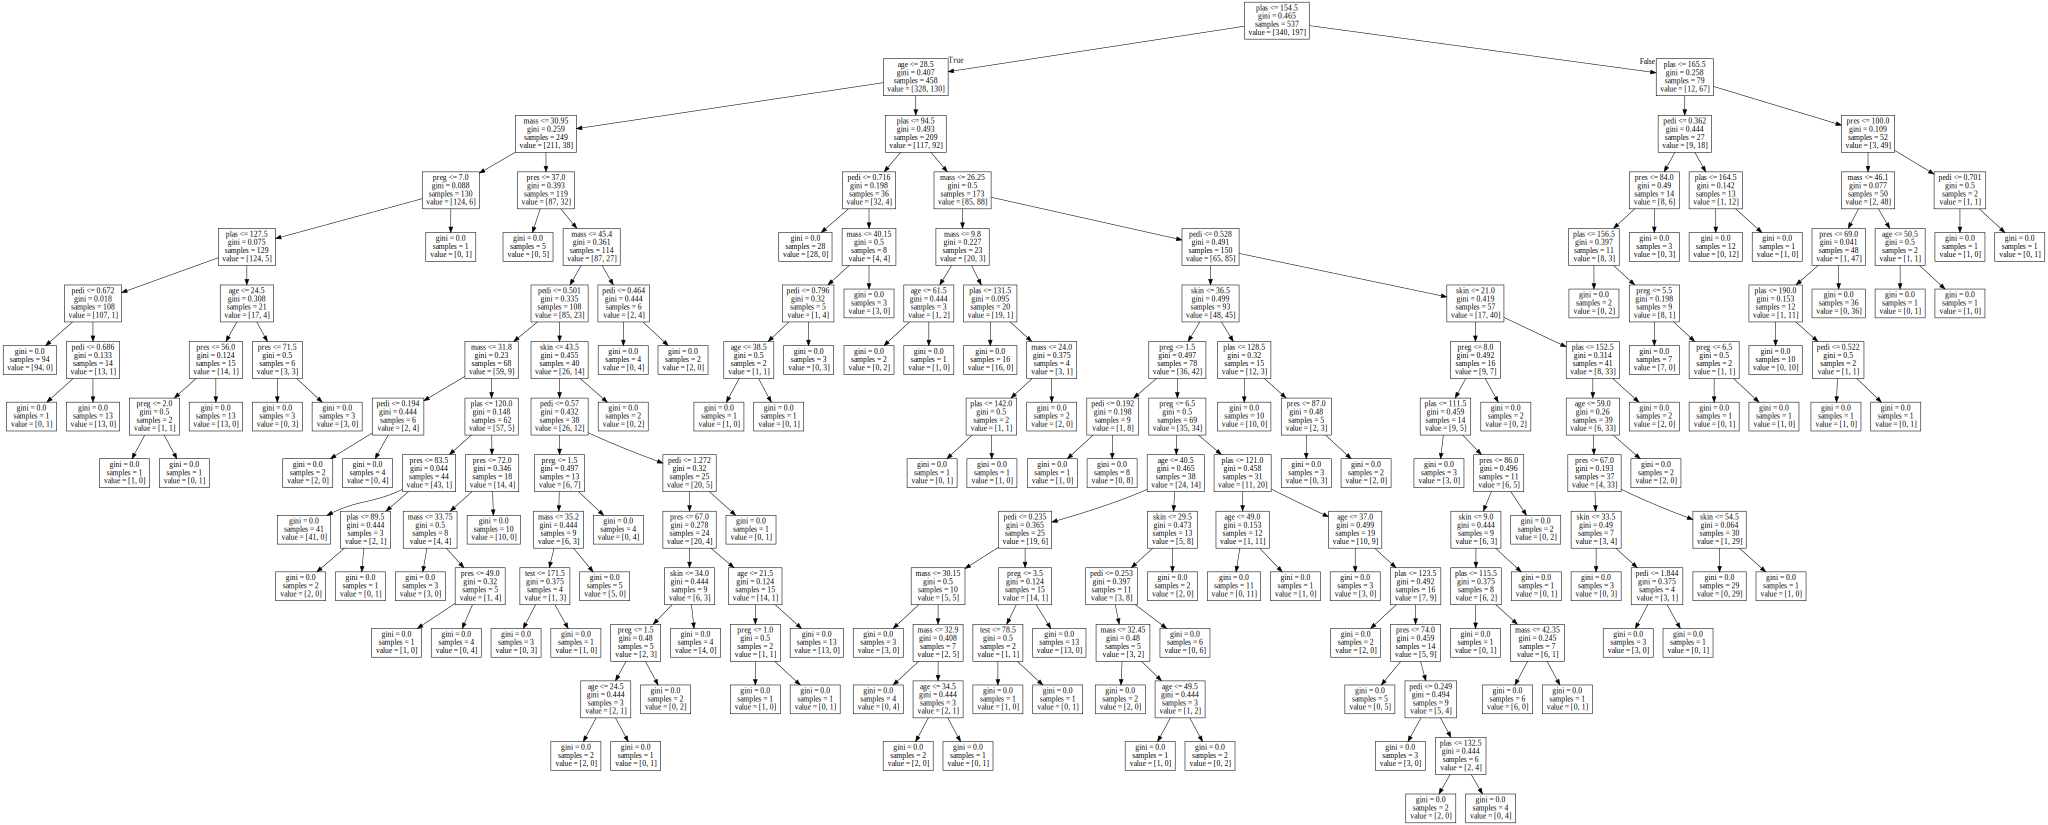

In [21]:
dot_data = tree.export_graphviz(clf, out_file=None,feature_names=feature_names) 
graph = graphviz.Source(dot_data)
graph

Now, use only two features from the dataset for the classification. Find the two features that result in the best classification accuracy.

['plas' 'age']
0.7316017316017316


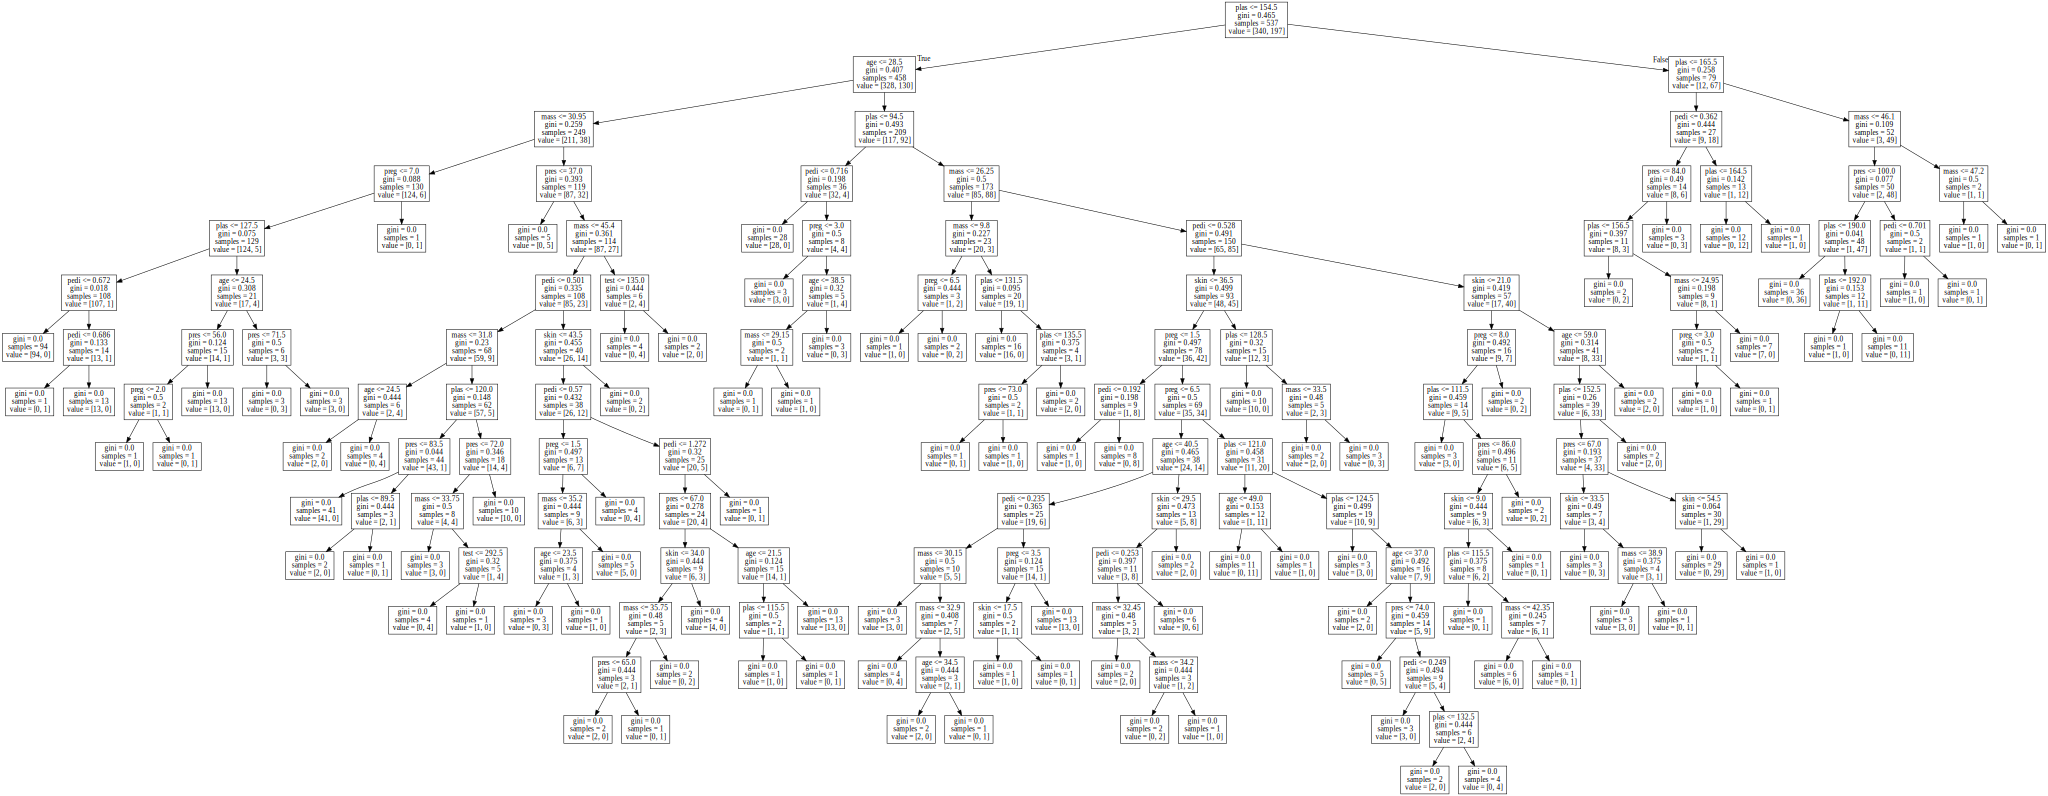

In [22]:
### BEGIN SOLUTION
indices = [1,7]
X_indices = X[:,indices]
names = np.array(feature_names)[indices]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=5)
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = metrics.accuracy_score(y_pred,y_test)
print(names)
print(acc)
dot_data = tree.export_graphviz(clf, out_file=None,feature_names=feature_names) 
graph = graphviz.Source(dot_data)
graph
### END SOLUTION

## Finding split points for trees - the Gini Index

We will find the best split point for the following toy dataset. Let us implement the Gini Index measure for this.

In [23]:
dataset = np.array([[11.7,183.2,0],
           [12.8,187.6,0],
           [15.3,177.4,0],
           [13.9,198.6,0],
           [17.2,175.3,0],
           [16.8,151.1,1],
           [17.5,171.4,1],
           [23.6,162.8,1],
           [16.9,179.5,1],
           [19.1,173.8,1]])
X = dataset[:,:-1]
y = dataset[:-1]

The following helper function is provided. It will separate a dataset into two lists of rows, given a feature and a split value for that feature.

In [24]:
def split(feature_id, value, dataset):
    left = []
    right = []
    for row in dataset:
        if row[feature_id] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right

Now, calculate the Gini Index for a given split

$gini(D) = 1 - \sum_{j=1}^K p_j^2$ where $K$ is the number of classes

If the dataset is split at value A into two datasets $D_1$ and $D_2$, the Gini index for the split is given by

$gini_A(D) = \frac{|D_1|}{|D|}gini(D_1) + \frac{|D_2|}{|D|}gini(D_2)$

In [25]:
def gini_index(groups, classes=[0,1]):
    n_instances = 10
    ### BEGIN SOLUTION
    # sum weighted Gini index for each group
    gini = 0.0
    for group in groups:
        size = len(group)
        # avoid divide by zero
        if size == 0:
            continue
        score = 0.0
        # score the group based on the score for each class
        for class_val in classes:
            p = [row[-1] for row in group].count(class_val) / size
            score += p * p
        # weight the group score by its relative size
        gini += (1.0 - score) * (size / n_instances)
    ### END SOLUTION
    return gini

groups = split(1,173.8,dataset)
print('Gini index for X2 < 173.8 = ' + str(gini_index(groups)))

Gini index for X2 < 173.8 = 0.2857142857142857


Now, we enumerate every possible split point and find its Gini index. The split that gives the lowest Gini index will be the best split. The following pseudocode should help with the implementation.

- For every feature $A$ in the dataset
    - For every row in the dataset
        - With feature $A$'s value as a split point, obtain the split and find its Gini index. 
        - If the Gini index is lower than the best score, save the split point
- Return the best split point

In [26]:
def get_split(dataset):
    best_score = 1
    ### BEGIN SOLUTION
    for feature_id in range(X.shape[1]):
        for row in dataset:
            groups = split(feature_id, row[feature_id], dataset)
            gini = gini_index(groups)
            print('X' + str(feature_id+1) + ' < ' + str(row[feature_id]) + ' Gini = ' + str(gini))
            if gini < best_score:
                best_feature, best_value, best_score, best_groups = feature_id, row[feature_id], gini, groups
    ### END SOLUTION
    return best_feature, best_value, best_groups

In [27]:
best_feature, best_value, _ = get_split(dataset)
print('Best split: X' + str(best_feature+1) + ' <  ' + str(best_value))

X1 < 11.7 Gini = 0.5
X1 < 12.8 Gini = 0.4444444444444444
X1 < 15.3 Gini = 0.2857142857142857
X1 < 13.9 Gini = 0.375
X1 < 17.2 Gini = 0.4166666666666667
X1 < 16.8 Gini = 0.1666666666666666
X1 < 17.5 Gini = 0.2857142857142857
X1 < 23.6 Gini = 0.4444444444444444
X1 < 16.9 Gini = 0.31999999999999984
X1 < 19.1 Gini = 0.375
X2 < 183.2 Gini = 0.2857142857142857
X2 < 187.6 Gini = 0.375
X2 < 177.4 Gini = 0.31999999999999984
X2 < 198.6 Gini = 0.4444444444444444
X2 < 175.3 Gini = 0.1666666666666666
X2 < 151.1 Gini = 0.5
X2 < 171.4 Gini = 0.375
X2 < 162.8 Gini = 0.4444444444444444
X2 < 179.5 Gini = 0.4166666666666667
X2 < 173.8 Gini = 0.2857142857142857
Best split: X1 <  16.8
